In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

In [2]:
Employee_table=pd.read_csv('Employee.csv')


In [5]:
Employee_table["HireDate"] = pd.to_datetime(Employee_table["HireDate"])
Employee_table['ExitDate'] = Employee_table.apply(
    lambda row: row['HireDate'] + pd.DateOffset(years=row['YearsAtCompany']) if row['Attrition'] == 'Yes' else 'Still Working',
    axis=1
)


In [11]:
df_left = Employee_table[Employee_table["Attrition"] == "Yes"]

df_left["ExitDate"] = pd.to_datetime(df_left["ExitDate"])



C:\Users\Ard Al Jood\AppData\Local\Temp\ipykernel_4420\1720794919.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_left["ExitDate"] = pd.to_datetime(df_left["ExitDate"])


In [12]:

# Aggregate monthly attrition counts
df_left["ExitMonth"] = df_left["ExitDate"].dt.to_period("M")
attrition_time_series = df_left.groupby("ExitMonth").size().rename("AttritionCount")

# Convert to a proper time series format
attrition_time_series = attrition_time_series.to_timestamp()

# Display the first few rows of the aggregated attrition time series
attrition_time_series.head()

C:\Users\Ard Al Jood\AppData\Local\Temp\ipykernel_4420\3523149406.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_left["ExitMonth"] = df_left["ExitDate"].dt.to_period("M")


ExitMonth
2013-04-01    1
2013-05-01    1
2014-02-01    1
2014-03-01    2
2014-05-01    1
Name: AttritionCount, dtype: int64

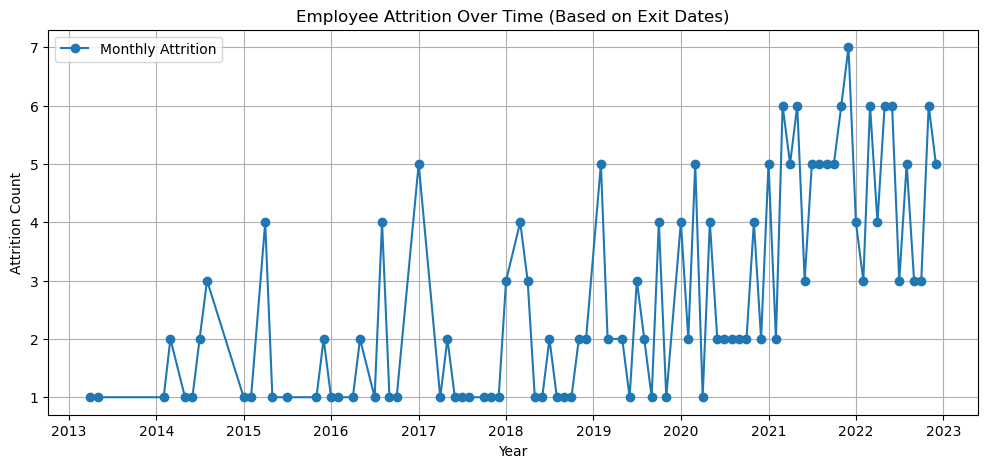

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(attrition_time_series, marker="o", linestyle="-", label="Monthly Attrition")
plt.xlabel("Year")
plt.ylabel("Attrition Count")
plt.title("Employee Attrition Over Time (Based on Exit Dates)")
plt.legend()
plt.grid(True)
plt.show()


#### Test if the series stationary or no 

In [14]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test
adf_test = adfuller(attrition_time_series.dropna())

# Extract results
adf_result = {
    "ADF Statistic": adf_test[0],
    "p-value": adf_test[1],
    "Critical Values": adf_test[4]
}

adf_result


{'ADF Statistic': -2.0555734986540948,
 'p-value': 0.26274963398894247,
 'Critical Values': {'1%': -3.5097356063504983,
  '5%': -2.8961947486260944,
  '10%': -2.5852576124567475}}

##### the series has unite root so it's not stationary  will apply the first difference method  

In [15]:
# Apply first-order differencing
attrition_diff = attrition_time_series.diff().dropna()

# Perform ADF test on differenced data
adf_test_diff = adfuller(attrition_diff)

# Extract results
adf_result_diff = {
    "ADF Statistic": adf_test_diff[0],
    "p-value": adf_test_diff[1],
    "Critical Values": adf_test_diff[4]
}

adf_result_diff


{'ADF Statistic': -8.536868996624035,
 'p-value': 1.0024995849414699e-13,
 'Critical Values': {'1%': -3.510711795769895,
  '5%': -2.8966159448223734,
  '10%': -2.5854823866213152}}

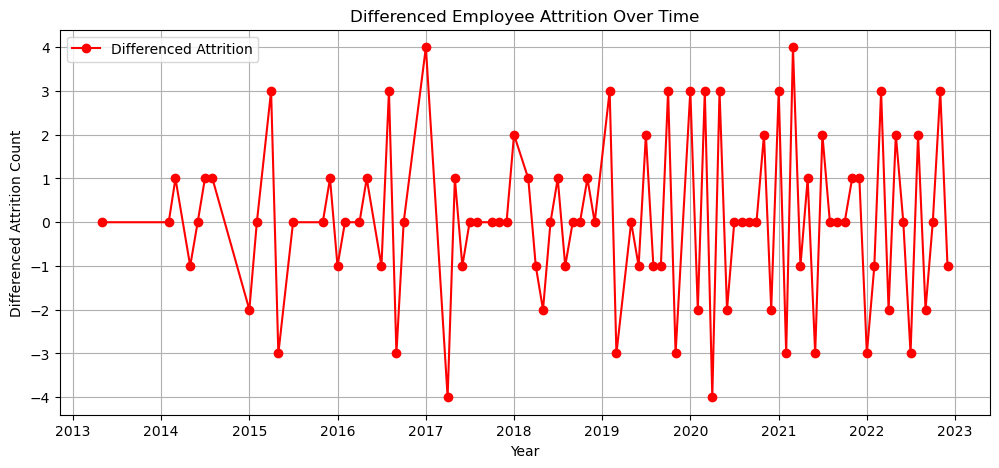

In [16]:

plt.figure(figsize=(12, 5))
plt.plot(attrition_diff, marker="o", linestyle="-", color="red", label="Differenced Attrition")
plt.xlabel("Year")
plt.ylabel("Differenced Attrition Count")
plt.title("Differenced Employee Attrition Over Time")
plt.legend()
plt.grid(True)
plt.show()


#### now the series stationary and ready  to apply the model 

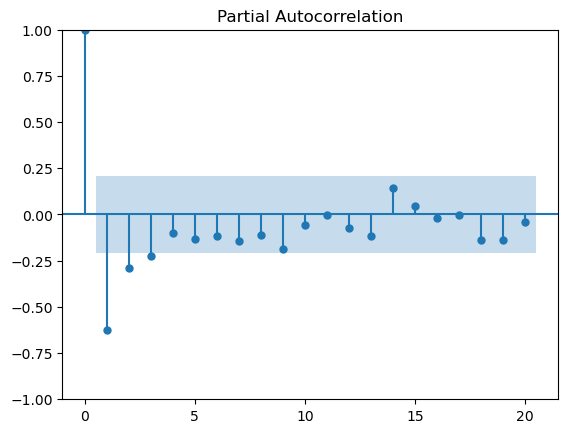

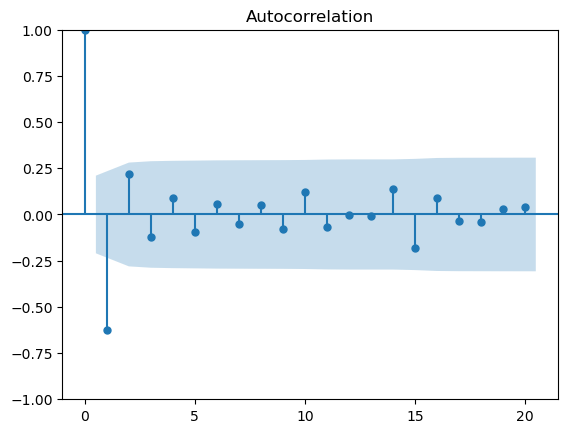

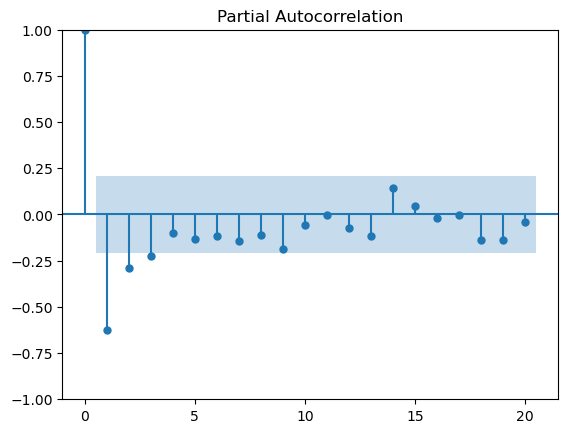

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(attrition_diff)
plot_pacf(attrition_diff)


d:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Ard Al Jood\AppData\Local\Temp\ipykernel_4420\1190527117.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=attrition_diff.index[-1], periods=13, freq="M")[1:]
d:\anaconda\Lib\sit

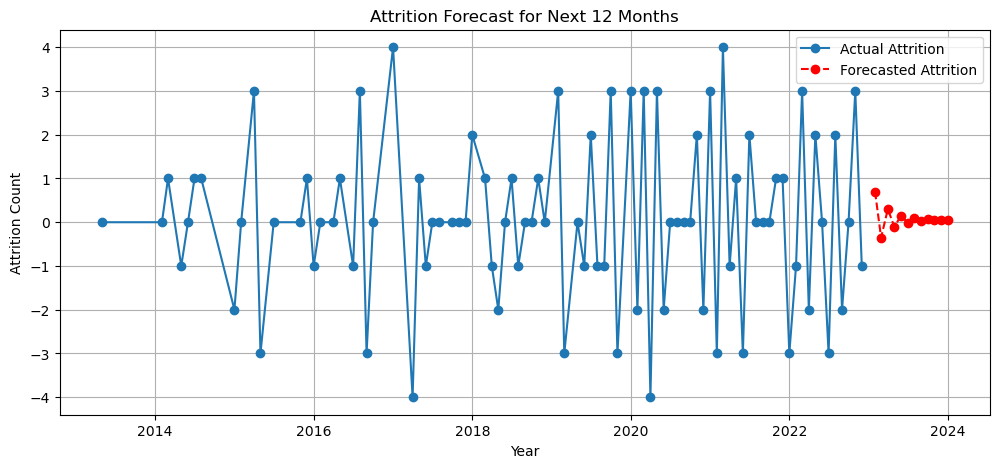

In [18]:

from statsmodels.tsa.arima.model import ARIMA

# Ensure the time series index is in datetime format
attrition_diff.index = pd.to_datetime(attrition_diff.index)
attrition_diff = attrition_diff.sort_index()

# Fit ARIMA(1,1,1) model
model = ARIMA(attrition_diff, order=(1,1,1))
model_fit = model.fit()

# Generate future dates for the next 12 months
future_dates = pd.date_range(start=attrition_diff.index[-1], periods=13, freq="M")[1:]

# Forecast next 12 months
forecast = model_fit.forecast(steps=12)
forecast.index = future_dates  # Assign correct future dates

# Plot actual vs forecasted values
plt.figure(figsize=(12, 5))
plt.plot(attrition_diff, marker="o", linestyle="-", label="Actual Attrition")
plt.plot(forecast.index, forecast, marker="o", linestyle="--", color="red", label="Forecasted Attrition")
plt.xlabel("Year")
plt.ylabel("Attrition Count")
plt.title("Attrition Forecast for Next 12 Months")
plt.legend()
plt.grid(True)
plt.show()



In [19]:
model = ARIMA(attrition_diff, order=(1,0,1))
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:         AttritionCount   No. Observations:                   87
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -147.153
Date:                Tue, 25 Mar 2025   AIC                            302.306
Time:                        13:27:09   BIC                            312.169
Sample:                             0   HQIC                           306.277
                                 - 87                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0418      0.025      1.666      0.096      -0.007       0.091
ar.L1         -0.1672      0.132     -1.271      0.204      -0.425       0.091
ma.L1         -0.8295      0.072    -11.543      0.0

d:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [20]:
model = ARIMA(attrition_diff, order=(0,0,1))
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:         AttritionCount   No. Observations:                   87
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -147.990
Date:                Tue, 25 Mar 2025   AIC                            301.981
Time:                        13:27:23   BIC                            309.378
Sample:                             0   HQIC                           304.960
                                 - 87                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0433      0.020      2.144      0.032       0.004       0.083
ma.L1         -0.8875      0.052    -17.012      0.000      -0.990      -0.785
sigma2         1.7270      0.394      4.387      0.0

d:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
